In [1]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns
from qtools import Submitter
import glob
from tqdm import tnrange, tqdm_notebook


Goal of this notebook is to see which genes I can run the script on. The criteria is that they have to be genes that correspond to a PacBio isoform (based on the classification.txt file and they have to be a gene with count >0. It also has to be a gene with at least two isoforms. 

In [3]:
working_dir = '/home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/'

In [4]:
data_dir = '/home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/PacBio_genome_scale_APOBEC_bugfix'


In [7]:
gene_counts = pd.read_csv('/home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/Pac_NP_counts_compare/countDFeByg.txt', sep = '\t', index_col = 0)

In [8]:
gene_counts.head()

,apobec_PromethION_all.sorted.bam,rps2_PromethION_all.sorted.bam,APO_PacBio_181120_merged.sorted.bam,RPS2_PacBio_181120_merged.sorted.bam
ENSG00000000003.10,706,936,177,180
ENSG00000000005.5,0,0,0,0
ENSG00000000419.8,410,699,16,10
ENSG00000000457.9,200,309,35,58
ENSG00000000460.12,167,307,109,151


In [9]:
gene_counts = gene_counts[['APO_PacBio_181120_merged.sorted.bam']]

In [10]:
gene_counts.shape

(57820, 1)

In [11]:
gene_counts = gene_counts[gene_counts['APO_PacBio_181120_merged.sorted.bam']>0]

In [12]:
gene_counts.shape

(14412, 1)

In [13]:
hg19_gencode_gtf = pd.read_csv('/home/pjaganna1/genomes/hg19/gencode.v19.annotation.gtf', sep='\t', skiprows=5, header=None)

In [14]:
def get_geneName_from_gtf(row):
    '''populating dictionary with ensemble ID key and gene name value from the provided GTF'''
    ensembl_to_geneName[row[8].split(';')[0].split('\"')[1]] = row[8].split(';')[4].split('\"')[1]
    gene_strand_chrom[row[8].split(';')[4].split('\"')[1]] = [row[6],
                                                              row[0]]  # storing gene and strand info for each gene

In [15]:
ensembl_to_geneName = {}
gene_strand_chrom = {}
hg19_gencode_gtf[hg19_gencode_gtf[2] == 'gene'].apply(get_geneName_from_gtf, axis=1)  # only processing 'gene' rows

0          None
21         None
82         None
92         None
100        None
           ... 
2619425    None
2619430    None
2619433    None
2619438    None
2619441    None
Length: 57820, dtype: object

In [16]:
gene_counts['gene_name'] = gene_counts.index.map(ensembl_to_geneName)

In [17]:
gene_counts.shape

(14412, 2)

In [18]:
gene_counts.head(10)

,APO_PacBio_181120_merged.sorted.bam,gene_name
ENSG00000000003.10,177,TSPAN6
ENSG00000000419.8,16,DPM1
ENSG00000000457.9,35,SCYL3
ENSG00000000460.12,109,C1orf112
ENSG00000001036.9,209,FUCA2
ENSG00000001084.6,51,GCLC
ENSG00000001167.10,25,NFYA
ENSG00000001460.13,29,STPG1
ENSG00000001461.12,65,NIPAL3
ENSG00000001497.12,233,LAS1L


In [ ]:
#gene_counts[gene_counts['gene_name']=='ZNF521']

In [19]:
classification_info = pd.read_csv(os.path.join(working_dir, '../apo_isoform.collapsed_classification.txt'), sep='\t')
classification_info_subset = classification_info[['isoform', 'chrom', 'associated_gene']]
classification_info_subset['gene_name'] = classification_info_subset['associated_gene'].map(
        ensembl_to_geneName).fillna(classification_info_subset['associated_gene'])

/home/pjaganna1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [20]:
gene_counts.head()

,APO_PacBio_181120_merged.sorted.bam,gene_name
ENSG00000000003.10,177,TSPAN6
ENSG00000000419.8,16,DPM1
ENSG00000000457.9,35,SCYL3
ENSG00000000460.12,109,C1orf112
ENSG00000001036.9,209,FUCA2


In [21]:
gene_list = []
for i in set(classification_info_subset['gene_name'].tolist()):
    if str(i) != 'nan':
        if ('novelGene' not in i) and ('ENSG' not in i):
            gene_list.append(i)

In [22]:
len(gene_list)

14790

In [23]:
common_genes = set(gene_list).intersection(set(gene_counts['gene_name'].tolist()))

In [24]:
classification_info_subset.head()

,isoform,chrom,associated_gene,gene_name
0,PB.1.1,chr1,ENSG00000227232.4,WASH7P
1,PB.1.10,chr1,ENSG00000227232.4,WASH7P
2,PB.1.11,chr1,ENSG00000227232.4,WASH7P
3,PB.1.12,chr1,ENSG00000227232.4,WASH7P
4,PB.1.13,chr1,ENSG00000227232.4,WASH7P


In [25]:
###This step takes a while 
final_gene_list = []
for gene in common_genes:
    if len(classification_info_subset[classification_info_subset['gene_name']==gene]['isoform'].tolist()) >=2:
        final_gene_list.append(gene)

In [26]:
len(final_gene_list)

11880

In [27]:
final_gene_list

['C1orf174',
 'DPH3',
 'EBNA1BP2',
 'CTD-2313N18.5',
 'ZNF708',
 'ODF2L',
 'HS6ST1',
 'GABPB2',
 'FYCO1',
 'ZNF772',
 'SAP30BP',
 'NBPF8',
 'ATP7A',
 'SMG1',
 'ASCC1',
 'DMKN',
 'POLR3F',
 'INO80E',
 'SLC16A5',
 'PON2',
 'TRPC4AP',
 'WDR47',
 'FUBP3',
 'RBM28',
 'CYB5D2',
 'MTMR10',
 'EDF1',
 'NBPF24',
 'FAXC',
 'FAM126B',
 'DTX3L',
 'SPC25',
 'SETD9',
 'RP11-1407O15.2',
 'PISD',
 'ZFYVE21',
 'NMU',
 'SEC62',
 'TOM1L1',
 'FAM20C',
 'ZUFSP',
 'PHF5A',
 'DNAJA3',
 'SPATA6',
 'PAICS',
 'TLE6',
 'QRFPR',
 'TRAK2',
 'SNRNP35',
 'TRIM65',
 'ADCY1',
 'MDFIC',
 'IGIP',
 'EFNB3',
 'FAM169A',
 'POLA2',
 'SPATA17',
 'BBS9',
 'ABCC1',
 'PAIP1',
 'AC013394.2',
 'TIMM8A',
 'ZNF385B',
 'RP11-387H17.4',
 'ACOX1',
 'FSTL3',
 'TRAF3IP2',
 'ZC3H7B',
 'APMAP',
 'CYP2J2',
 'TIAL1',
 'ACAT1',
 'C16orf70',
 'NUDT6',
 'FAM45A',
 'KIF21A',
 'CEP44',
 'LIPT1',
 'HMCN1',
 'VAC14',
 'TUBB2B',
 'B4GALT6',
 'SDHAF1',
 'CNOT2',
 'VPS51',
 'SCNM1',
 'CD164',
 'KANK1',
 'WNT3A',
 'LAMA4',
 'TWF1',
 'KIF27',
 'REEP3',


In [27]:
############Don't run this again###################################################
###################################################################################
#def make_chunks(list_to_chunk, size):
chunk1 = len(final_gene_list)//24
chunk2 = chunk1//5

count = 1
for g in range(0, len(final_gene_list), chunk1):
    if g+chunk1 > len(final_gene_list)==True:
        list_chunk = final_gene_list[g:]
    else:
        list_chunk = final_gene_list[g:g+chunk1]
    cmds = []
    for y in range(0, len(list_chunk), 5):
        if y+5 > len(list_chunk) == True:
            sub_list_chunk = list_chunk[y:]
        else:
            sub_list_chunk = list_chunk[y:y+5]
        
        cmd = ['module load python3essential']
        for each in sub_list_chunk:
            cmd.append('python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ ' + each)
        cmds.append(';'.join(cmd))
    ###Submitter(cmds, 'apobec_pacbio_quant_chunk_' + str(count) , nodes=1, ppn=2, walltime='48:00:00', array=True, submit=False)
    count += 1
    print('\n'.join(cmds))
    print('\n')
    print('\n')

Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_1.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_2.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_3.sh.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ PRKCD;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ ALDH1B1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ FZD7;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edi

Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_4.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_5.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_6.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_7.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_8.sh.
Writing 99 tasks as an array-job.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ RRAGD;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ LINC00205;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ CDK8;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_e

Wrote commands to apobec_pacbio_quant_chunk_9.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_10.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_11.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_12.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_13.sh.
Writing 99 tasks as an array-job.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ RBL2;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ SAYSD1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ KATNB1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edi

Wrote commands to apobec_pacbio_quant_chunk_14.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_15.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_16.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_17.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_18.sh.
Writing 99 tasks as an array-job.
Wrote commands to apobec_pacbio_quant_chunk_19.sh.


module load python3essential;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ COLGALT1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ TOE1;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_edits/percent_edited_reads_quantification/ XPNPEP3;python3 /home/pjaganna1/scratch/PacBio_genome_scale_APOBEC_bugfix/submitter_script/genome-wide-pac-APOBEC-bugfix.py --window 10 /home/pjaganna1/projects/STAMP/RPS2/PacBIO_Rps2_RBFOX2_Apobec/APOBEC_isoform_

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
chunk1 = len(final_gene_list)//24
gene_chunks = {}
count = 1
for g in range(0, len(final_gene_list), chunk1):
    if g+chunk1 > len(final_gene_list)==True:
        list_chunk = final_gene_list[g:]
    else:
        list_chunk = final_gene_list[g:g+chunk1]
    chunk_name = 'chunk_' + str(count)
    gene_chunks[chunk_name] = list_chunk
    count +=1

In [29]:
gene_chunks

{'chunk_1': ['C1orf174',
  'DPH3',
  'EBNA1BP2',
  'CTD-2313N18.5',
  'ZNF708',
  'ODF2L',
  'HS6ST1',
  'GABPB2',
  'FYCO1',
  'ZNF772',
  'SAP30BP',
  'NBPF8',
  'ATP7A',
  'SMG1',
  'ASCC1',
  'DMKN',
  'POLR3F',
  'INO80E',
  'SLC16A5',
  'PON2',
  'TRPC4AP',
  'WDR47',
  'FUBP3',
  'RBM28',
  'CYB5D2',
  'MTMR10',
  'EDF1',
  'NBPF24',
  'FAXC',
  'FAM126B',
  'DTX3L',
  'SPC25',
  'SETD9',
  'RP11-1407O15.2',
  'PISD',
  'ZFYVE21',
  'NMU',
  'SEC62',
  'TOM1L1',
  'FAM20C',
  'ZUFSP',
  'PHF5A',
  'DNAJA3',
  'SPATA6',
  'PAICS',
  'TLE6',
  'QRFPR',
  'TRAK2',
  'SNRNP35',
  'TRIM65',
  'ADCY1',
  'MDFIC',
  'IGIP',
  'EFNB3',
  'FAM169A',
  'POLA2',
  'SPATA17',
  'BBS9',
  'ABCC1',
  'PAIP1',
  'AC013394.2',
  'TIMM8A',
  'ZNF385B',
  'RP11-387H17.4',
  'ACOX1',
  'FSTL3',
  'TRAF3IP2',
  'ZC3H7B',
  'APMAP',
  'CYP2J2',
  'TIAL1',
  'ACAT1',
  'C16orf70',
  'NUDT6',
  'FAM45A',
  'KIF21A',
  'CEP44',
  'LIPT1',
  'HMCN1',
  'VAC14',
  'TUBB2B',
  'B4GALT6',
  'SDHAF1',
  'CN

In [30]:
[len(gene_chunks[i]) for i in gene_chunks]

[495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495,
 495]

Checking that all files for all genes have something in them.

In [31]:
for gene in tqdm(final_gene_list):
    if os.path.exists(data_dir + '/' + gene + '_quantification_output.txt') ==True:
        if os.path.getsize(data_dir + '/' + gene + '_quantification_output.txt') == 0:
            print('File for {} is empty'.format(gene))
    else:
        print('File for {} does not exist'.format(gene))

  8%|▊         | 973/11880 [00:00<00:03, 3205.51it/s]

File for RBL1 does not exist


 17%|█▋        | 2013/11880 [00:00<00:02, 3370.07it/s]

File for CKS1B does not exist


 29%|██▊       | 3386/11880 [00:01<00:02, 3417.37it/s]

File for LGALSL does not exist
File for MIR4519 does not exist
File for VAMP7 does not exist


 58%|█████▊    | 6858/11880 [00:02<00:01, 3419.94it/s]

File for KBTBD4 does not exist
File for SNORA76 does not exist
File for ZNF668 does not exist
File for DHRS4-AS1 does not exist


 89%|████████▉ | 10631/11880 [00:03<00:00, 3310.83it/s]

File for 7SK does not exist


100%|██████████| 11880/11880 [00:03<00:00, 3379.89it/s]


In [32]:
genome_wide_gene = []
genome_wide_isoA = []
genome_wide_isoB = []
genome_wide_bins = []
for c in gene_chunks:
    print('Processing {}'.format(c))
    for gene in tqdm(gene_chunks[c]):
        if os.path.exists(data_dir + '/' + gene + '_quantification_output.txt') ==True:
            df = pd.read_csv(os.path.join(data_dir, gene + '_quantification_output.txt'), sep = '\t')
            if len(df) >1:
                df = df.sort_values('num_reads', ascending = False).iloc[:2,:]
                if len(df.dropna()) > 1:
                    if df.iloc[0,5]>=10 and df.iloc[1,5]>=10:
                        if df.iloc[0]['num_reads']/df.iloc[1]['num_reads']<=5:
                            genome_wide_gene.append(gene)
                            bins = [str(b) for b in df['bin'].tolist()]
                            genome_wide_bins.append(','.join(bins))
                            genome_wide_isoA.append(df.iloc[0]['percent reads edited'])
                            genome_wide_isoB.append(df.iloc[1]['percent reads edited'])
        

  2%|▏         | 9/495 [00:00<00:05, 83.55it/s]

Processing chunk_1


  3%|▎         | 13/495 [00:00<00:03, 125.82it/s]

Processing chunk_2


  3%|▎         | 13/495 [00:00<00:03, 124.13it/s]

Processing chunk_3


  3%|▎         | 13/495 [00:00<00:03, 129.61it/s]

Processing chunk_4


  3%|▎         | 14/495 [00:00<00:03, 137.07it/s]

Processing chunk_5


  3%|▎         | 13/495 [00:00<00:03, 129.58it/s]

Processing chunk_6


  3%|▎         | 14/495 [00:00<00:03, 136.01it/s]

Processing chunk_7


  3%|▎         | 14/495 [00:00<00:03, 130.33it/s]

Processing chunk_8


  3%|▎         | 14/495 [00:00<00:03, 130.35it/s]

Processing chunk_9


  3%|▎         | 15/495 [00:00<00:03, 139.63it/s]

Processing chunk_10


  3%|▎         | 13/495 [00:00<00:03, 125.72it/s]

Processing chunk_11


  3%|▎         | 14/495 [00:00<00:03, 133.32it/s]

Processing chunk_12


  2%|▏         | 10/495 [00:00<00:04, 98.11it/s]

Processing chunk_13


  3%|▎         | 15/495 [00:00<00:03, 142.40it/s]

Processing chunk_14


  3%|▎         | 15/495 [00:00<00:03, 144.95it/s]

Processing chunk_15


  3%|▎         | 14/495 [00:00<00:03, 133.05it/s]

Processing chunk_16


  3%|▎         | 15/495 [00:00<00:03, 144.26it/s]

Processing chunk_17


  3%|▎         | 13/495 [00:00<00:03, 128.28it/s]

Processing chunk_18


  3%|▎         | 13/495 [00:00<00:03, 128.51it/s]

Processing chunk_19


  2%|▏         | 12/495 [00:00<00:04, 118.07it/s]

Processing chunk_20


  3%|▎         | 14/495 [00:00<00:03, 133.85it/s]

Processing chunk_21


  3%|▎         | 14/495 [00:00<00:03, 133.65it/s]

Processing chunk_22


  2%|▏         | 8/495 [00:00<00:06, 79.46it/s]

Processing chunk_23


  2%|▏         | 12/495 [00:00<00:04, 109.69it/s]

Processing chunk_24


100%|██████████| 495/495 [00:04<00:00, 117.94it/s]


In [33]:
table=pd.DataFrame({'Gene':genome_wide_gene, 'bins':genome_wide_bins, 'IsoA': genome_wide_isoA, 'IsoB': genome_wide_isoB})

In [34]:
table = table.set_index('Gene')

In [35]:
table.shape

(1878, 3)

In [36]:
table.head()

,bins,IsoA,IsoB
Gene,,,
SAP30BP,"6,7",0.000000,0.076923
RBM28,"8,10",0.000000,0.000000
SEC62,"16,6",0.086957,0.111111
DNAJA3,"4,3",0.008439,0.013514
PAIP1,"6,7",0.000000,0.031250


In [37]:
table.to_csv(os.path.join(working_dir, 'Apobec_genome_scale_pacbio_percent_edited_reads_bugfix.txt'), sep = '\t')

In [38]:
table['dif'] = table['IsoA']-table['IsoB']

In [39]:
table = table.sort_values('dif', ascending = False)

In [40]:
table.head()

,bins,IsoA,IsoB,dif
Gene,,,,
CCDC25,"0,3",0.974359,0.343750,0.630609
PKNOX1,"15,10",0.545455,0.000000,0.545455
LEPROT,"3,5",0.633333,0.250000,0.383333
ING5,"5,3",0.368421,0.000000,0.368421
ACSL3,"10,9",0.376344,0.011628,0.364716


In [41]:
table[table.index=='CSDE1']

,bins,IsoA,IsoB,dif
Gene,,,,
CSDE1,"2,3",0.028618,0.025074,0.003544


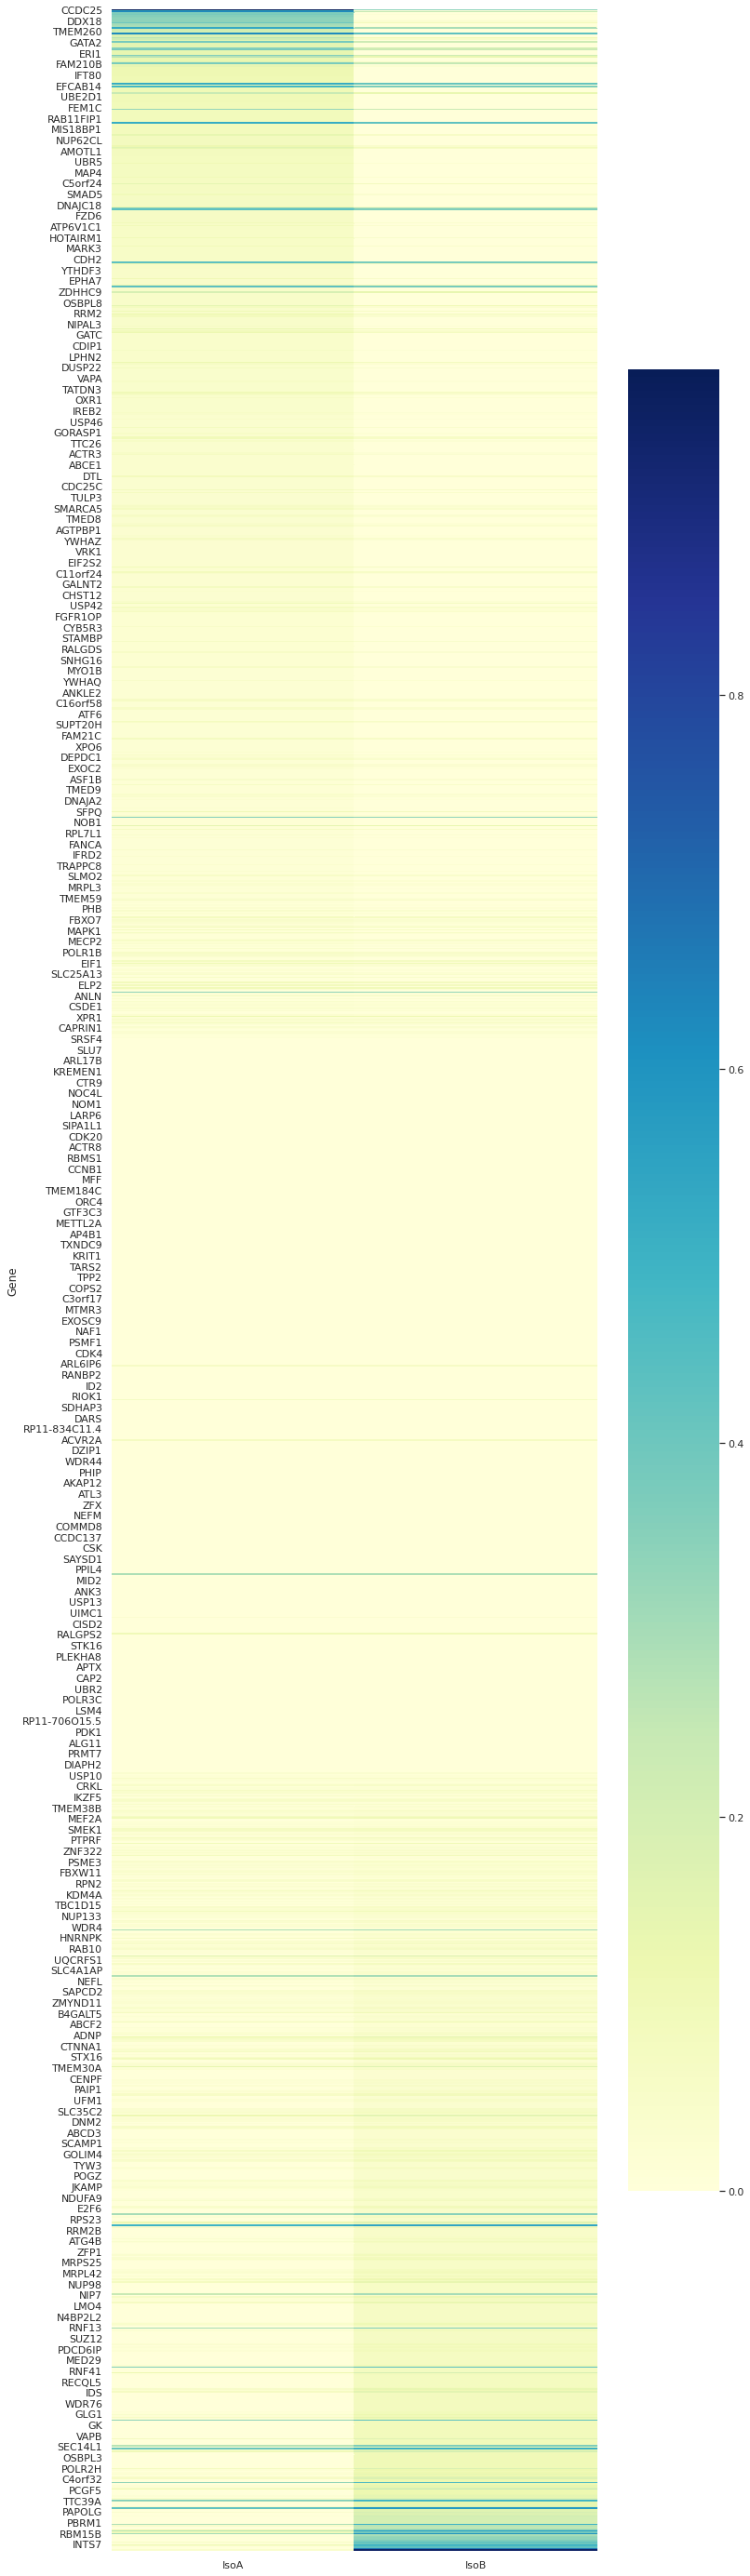

In [43]:
sns.set(rc={'figure.figsize':(11.7,50.27)})
ax = sns.heatmap(table[['IsoA', 'IsoB']],cmap="YlGnBu")
plt.savefig(os.path.join(working_dir,'APOBEC_heatmap.png'))
plt.savefig(os.path.join(working_dir,'APOBEC_heatmap.svg'))

In [ ]:
table[table.index=='APP']

In [ ]:
k_list = ['PIGN','MAP3K7','SYNCRIP', 'QKI', 'HNRNPK', 'TIA1', 'EIF4EBP2', 'HNRNPC', 'USP34', 'FMR1', 'SLC25A32', 'RPN1', 'PLAGL1', 'HNRNPA3', 'FAR1', 'U2SURP', 'CHTOP']

In [ ]:
len(k_list)

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(table[table.index.isin(k_list)].sort_values('dif', ascending = False)[['IsoA', 'IsoB']],cmap="YlGnBu")


In [ ]:
table_subset_countcutoff50 = table[table.index.isin(gene_counts[gene_counts['RBFOX_PacBio_181120_merged.sorted.bam']>20]['gene_name'].tolist())]

In [ ]:
sns.set(rc={'figure.figsize':(11.7,50.27)})
ax = sns.heatmap(table_subset_countcutoff50[['IsoA', 'IsoB']],cmap="YlGnBu")

In [ ]:
table_subset_countcutoff50[table_subset_countcutoff50['Gene']=='FAR1']

In [ ]:
df.loc[0]['num_reads']/df.loc[1]['num_reads']

In [ ]:
df

In [ ]:
df_test = df.sort_values('num_reads', ascending = False).iloc[:2,:]

In [ ]:
df_test

In [ ]:
df_test.iloc[0]['num_reads']/df_test.iloc[1]['num_reads'] < 5

In [ ]:
df_test.iloc[1]